## Task at hand:

Conduct the analysis of the tweets to figure out any guidelines that would help owner of the twitter channel increase their engagement with the users. To do that, the following tasks will be performed:
1. Prepare the raw data for processing. Address any issues with the data accordingly.
2. Exploratory data analysis
3. Create a machine learning pipeline that extracts relevant features from each
of the tweets. Use these features to predict how many likes a tweet is likely to
get.
4. Compare the accuracy across three different algorithms of choice.

In [1]:
#load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

#import the csv file
url = 'https://github.com/nickpostovoi/projects/blob/673bbf6547d13594346e53f33fd9aceb2ff7dd32/Text%20Mining%20and%20Twitter/trump.csv?raw=true'
data = pd.read_csv(url)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56571 entries, 0 to 56570
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       56571 non-null  object
 1   likes      56571 non-null  int64 
 2   retweets   56571 non-null  int64 
 3   date       56571 non-null  object
 4   isFlagged  56571 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.2+ MB


Calculating the time since last tweet in minutes (doing this before filtering out any observartions)

In [2]:
# converting the datestamp column to a proper format
data['date'] = pd.to_datetime(data['date'], format="%d/%m/%Y %H:%M")
# sort observations by their timestamp
data = data.sort_values('date')
# calculate the time
data['minutes_since_last_tweet'] = data['date'] - data['date'].shift(1)
# convert it to minutes
data['minutes_since_last_tweet'] = data['minutes_since_last_tweet'].astype('timedelta64[s]')/60
# randomize the order of observations (undo sorting)
data = data.sample(frac=1).reset_index(drop=True)

Visualizing the frequency of tweets

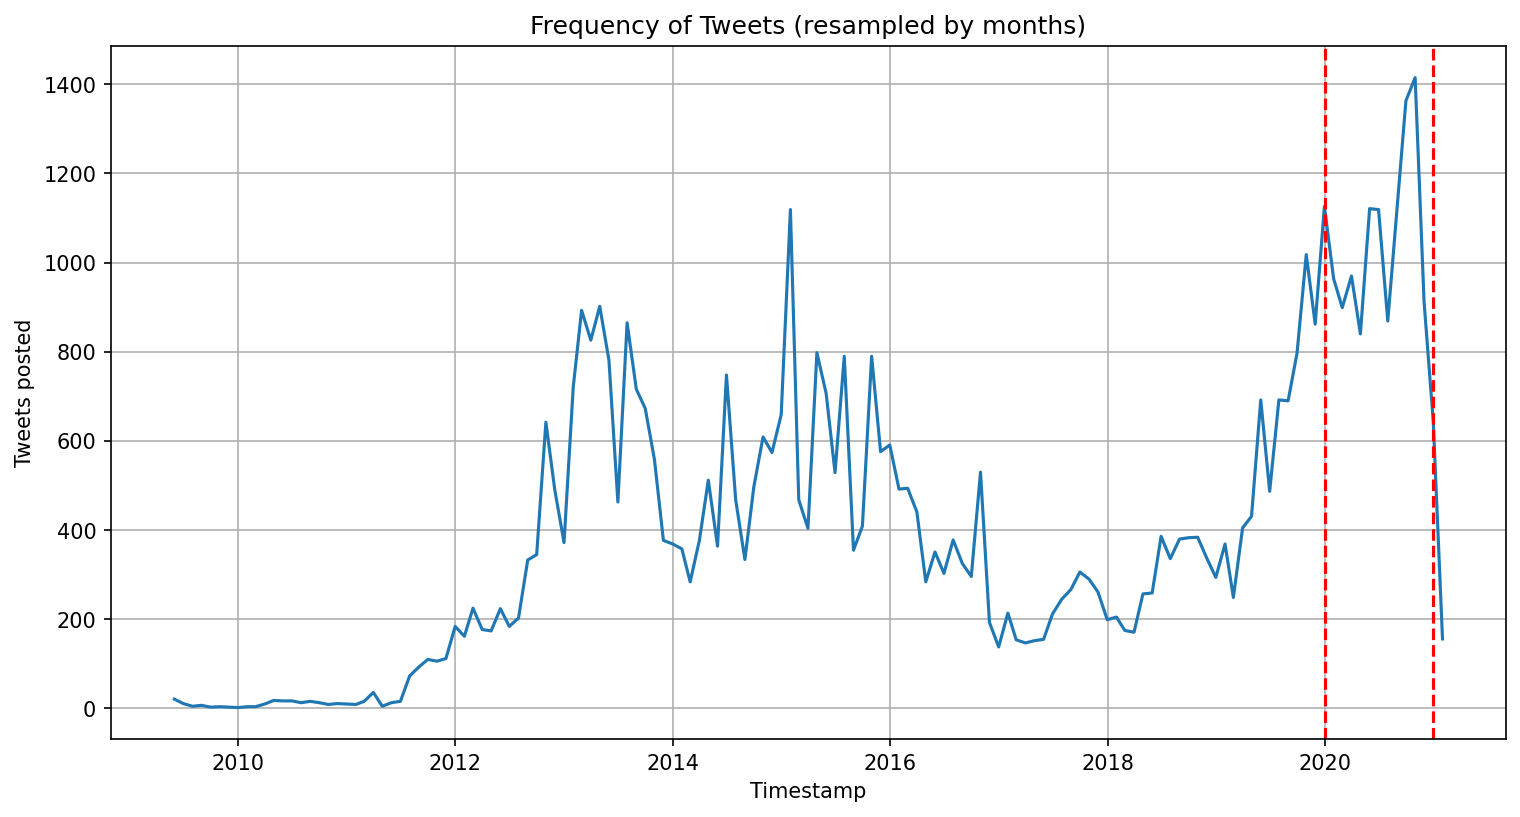

In [3]:
# resampling frequency by months
monthly_tweets = data.resample('M', on='date').count()

# plotting the data
plt.figure(figsize=(12, 6), dpi=150)
plt.plot(monthly_tweets.index, monthly_tweets['text'])
plt.xlabel('Timestamp')
plt.ylabel('Tweets posted')
plt.title('Frequency of Tweets (resampled by months)')
plt.grid(True)
plt.axvline(pd.to_datetime('2020-01-01'), color='red', linestyle='--')
plt.axvline(pd.to_datetime('2020-12-31'), color='red', linestyle='--')
plt.show()

Filtering the dataframe

In [4]:
# filtering the dataframe to include only the tweets for year 2020
data = data[(data['date'] >= pd.to_datetime('2020-01-01')) & (data['date'] <= pd.to_datetime('2020-12-31'))]
# filtering out the retweets (contain RT tag)
data = data[~data['text'].str.contains('RT', case=False)]

Visualizing daily average likes and retweets in 2020

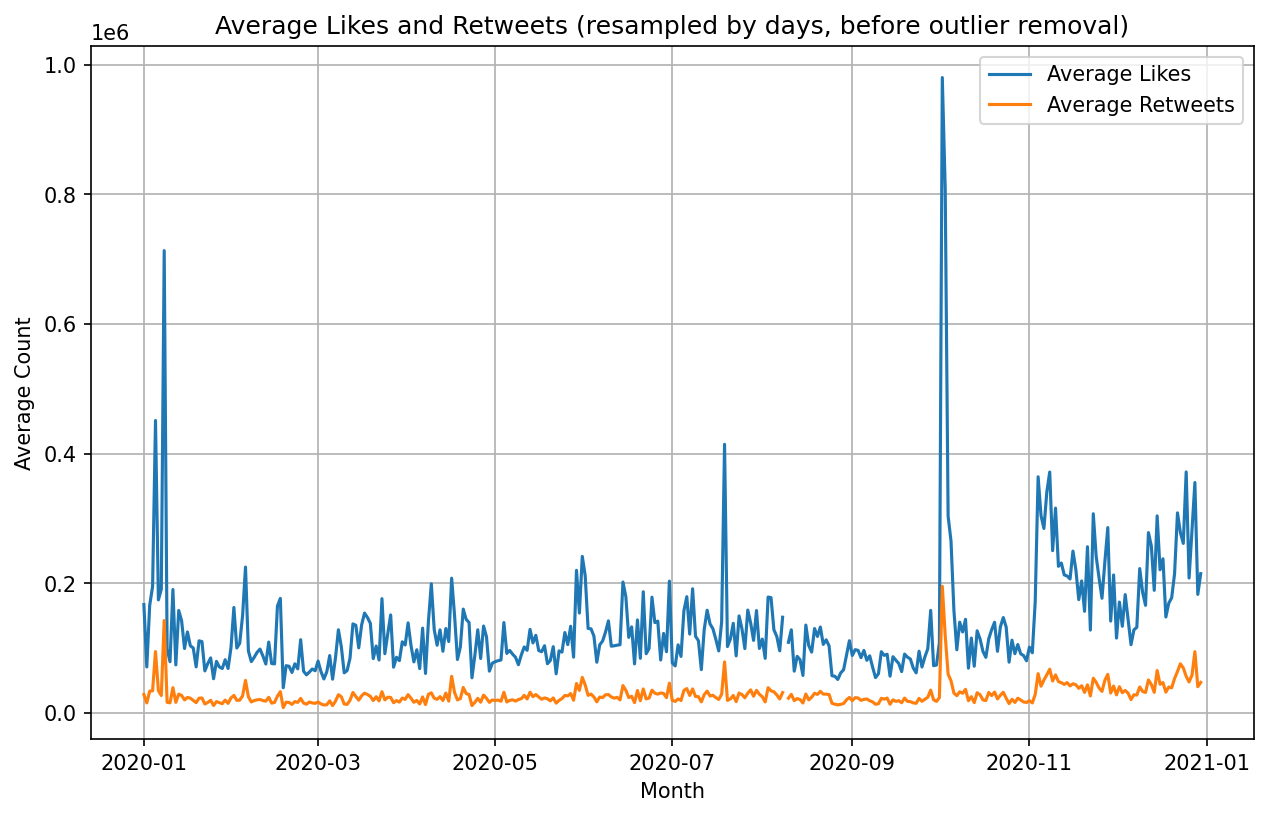

In [5]:
#resample the data by day and compute the averages
monthly_mean = data[['likes', 'retweets', 'date']].resample('D', on='date').mean()
#plot the data
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(monthly_mean.index, monthly_mean['likes'], label='Average Likes')
plt.plot(monthly_mean.index, monthly_mean['retweets'], label='Average Retweets')
plt.xlabel('Month')
plt.ylabel('Average Count')
plt.title('Average Likes and Retweets (resampled by days, before outlier removal)')
plt.grid(True)
plt.legend()
plt.show()

Filtering out outliers (top 1% most liked posts)

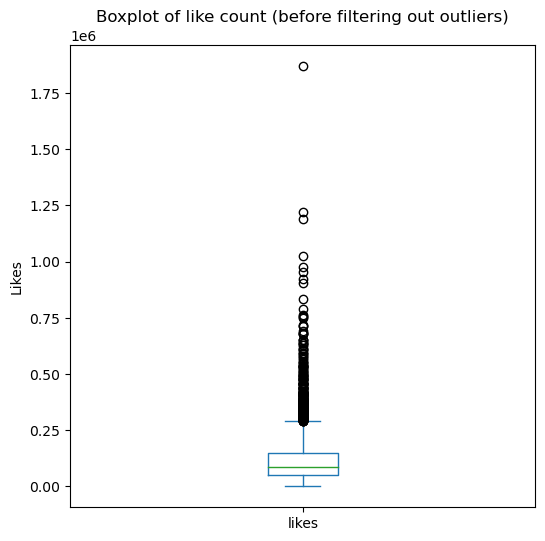

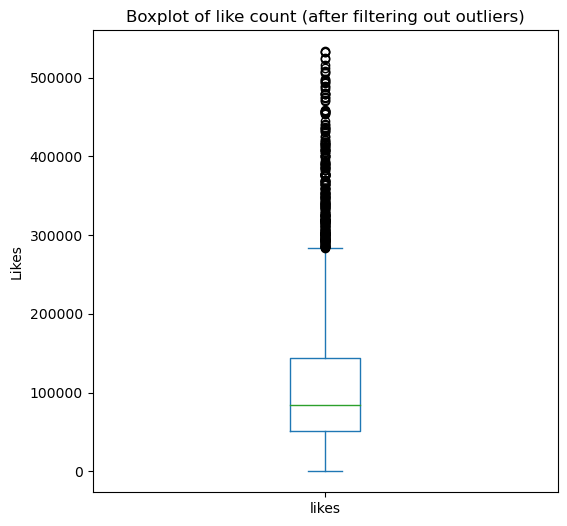

In [6]:
#plot the boxplot to visualise outliers
plt.figure(figsize=(6, 6), dpi=100)
data['likes'].plot(kind='box')
plt.ylabel('Likes')
plt.title('Boxplot of like count (before filtering out outliers)')
plt.show()

#filter out
data = data[data['likes'] <  data['likes'].quantile(0.99)]

# plot the boxplot after filtering
plt.figure(figsize=(6, 6), dpi=100)
data['likes'].plot(kind='box')
plt.ylabel('Likes')
plt.title('Boxplot of like count (after filtering out outliers)')
plt.show()

Visualise the daily average likes and tweets after outlier removal

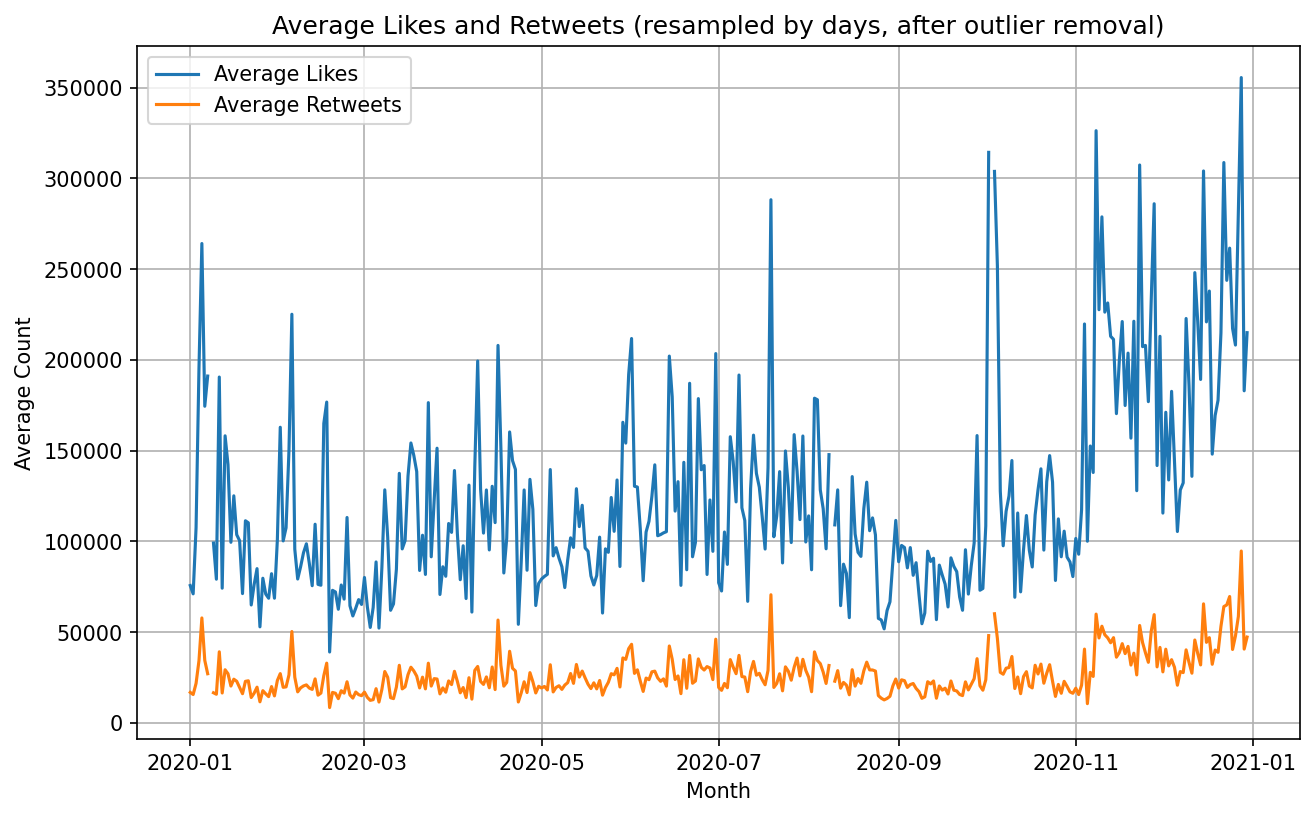

In [7]:
monthly_mean = data[['likes', 'retweets', 'date']].resample('D', on='date').mean()

plt.figure(figsize=(10, 6), dpi=150)
plt.plot(monthly_mean.index, monthly_mean['likes'], label='Average Likes')
plt.plot(monthly_mean.index, monthly_mean['retweets'], label='Average Retweets')
plt.xlabel('Month')
plt.ylabel('Average Count')
plt.title('Average Likes and Retweets (resampled by days, after outlier removal)')
plt.grid(True)
plt.legend()
plt.show()

**Feature engineering**

Defining a function to evaluate the distribution of a column

In [8]:
#function to plot a histogram of the distribution of counts between unique values in a column
def plot_count_distribution(data, column):
    counts = data.groupby(column).size()

    fig, ax = plt.subplots(figsize=(3,3), dpi=100)
    ax.bar(counts.index, counts.values)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(f'Class distribution of {column} variable')
    plt.show()

Creating a binary variable that will represent occurence of special events on a specific day

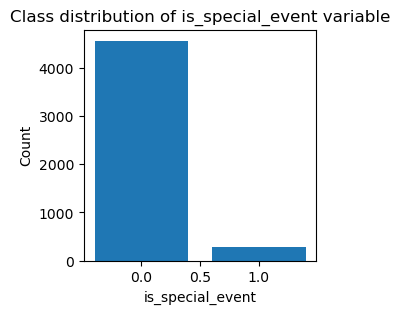

In [9]:
#create a list of events for 2020
special_events = [
    {'name': 'New Year', 'date': '2020-01-01'},
    {'name': 'US-Iran Conflict', 'date': '2020-01-03'},
    {'name': 'Impeachment Trial Begins', 'date': '2020-01-16'},
    {'name': 'World Economic Forum Davos', 'date': '2020-01-21'},
    {'name': 'Trump Acquitted in Impeachment Trial', 'date': '2020-02-05'},
    {'name': 'Super Bowl LIV', 'date': '2020-02-02'},
    {'name': 'COVID-19 Declared a Pandemic by WHO', 'date': '2020-03-11'},
    {'name': 'US National Emergency Declaration', 'date': '2020-03-13'},
    {'name': 'Easter', 'date': '2020-04-12'},
    {'name': 'George Floyd Protests Begin', 'date': '2020-05-26'},
    {'name': 'Independence Day', 'date': '2020-07-04'},
    {'name': 'Trump Commutes Roger Stone Sentence', 'date': '2020-07-10'},
    {'name': 'Democratic National Convention', 'date': '2020-08-17'},
    {'name': 'Republican National Convention', 'date': '2020-08-24'},
    {'name': 'First Presidential Debate', 'date': '2020-09-29'},
    {'name': 'Trump Tests Positive for COVID-19', 'date': '2020-10-02'},
    {'name': 'VP Debate', 'date': '2020-10-07'},
    {'name': 'Second Presidential Debate', 'date': '2020-10-22'},
    {'name': 'US Presidential Election Day', 'date': '2020-11-03'},
    {'name': 'Joe Biden Declared Winner', 'date': '2020-11-07'},
    {'name': 'Thanksgiving', 'date': '2020-11-26'},
    {'name': 'Electoral College Vote', 'date': '2020-12-14'},
    {'name': 'Christmas', 'date': '2020-12-25'},
    {'name': 'New Year\'s Eve', 'date': '2020-12-31'}
]
event_dates = set(event['date'] for event in special_events)

#create a binary variable
data['is_special_event'] = data['date'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in event_dates else 0)

#plot the variable class distribution
plot_count_distribution(data, 'is_special_event')

Creating a variable 'link' indicating whether a link is present in the tweet

C:\Users\ggnik\AppData\Local\Temp\ipykernel_23532\9532050.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data['link'] = data['text'].str.contains(link_pattern, flags=re.IGNORECASE).astype(int)


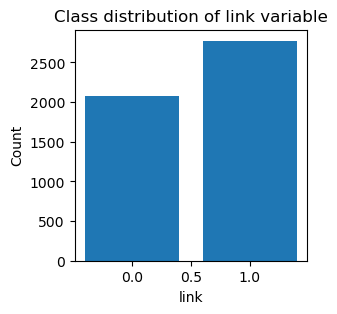

In [10]:
link_pattern = r'(https?://\S+)'
data['link'] = data['text'].str.contains(link_pattern, flags=re.IGNORECASE).astype(int)

#remove the links themselves from the text of a tweet
data['text'] = data['text'].str.replace(link_pattern, '', flags=re.IGNORECASE)

#drop the blank rows introduced by deleting links from the tweet
data = data[data['text'].str.strip() != '']

#plot the variable class distribution
plot_count_distribution(data, 'link')

Creating variables that will represent word count and character count of a tweet

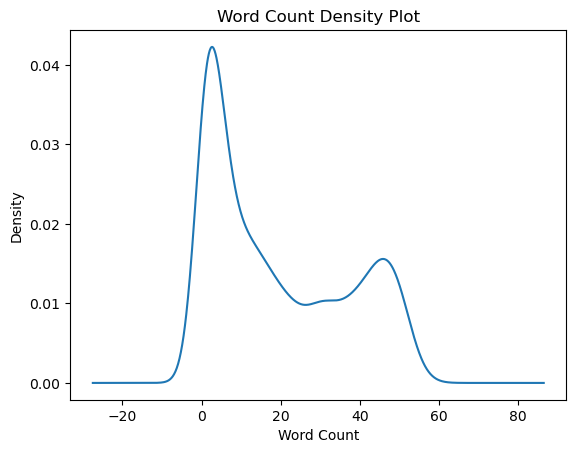

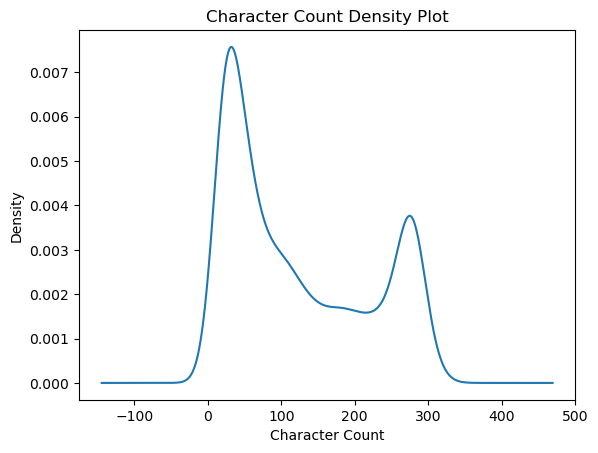

In [11]:
data['word_count'] = data['text'].apply(lambda x: len(x.split()))

data['word_count'].plot(kind='density')
plt.title('Word Count Density Plot')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.show()

data['char_count'] = data['text'].apply(lambda x: len(x))

data['char_count'].plot(kind='density')
plt.title('Character Count Density Plot')
plt.xlabel('Character Count')
plt.ylabel('Density')
plt.show()

Creating a variable indicating usage of emojis in a tweet

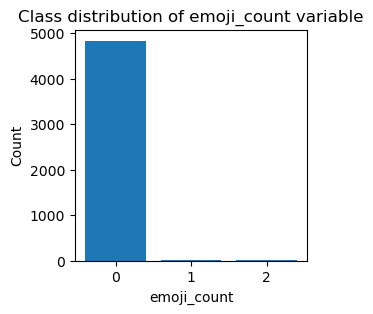

In [12]:
import emoji
data['emoji_count'] = data['text'].apply(emoji.emoji_count)

plot_count_distribution(data, 'emoji_count')

Creating variables representing exclamation mark count and question mark count

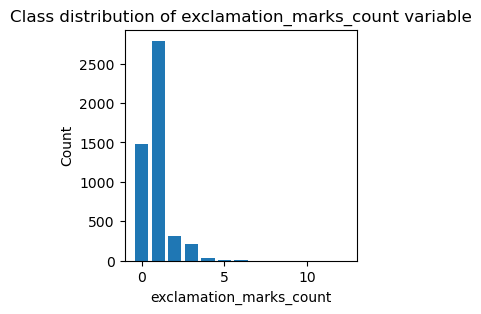

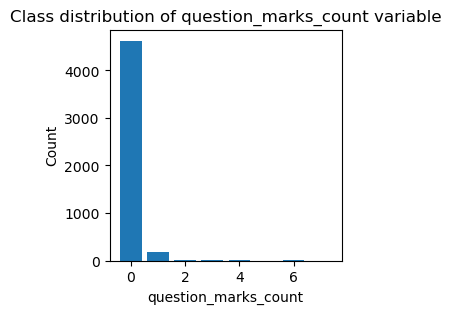

In [13]:
data['exclamation_marks_count'] = data['text'].apply(lambda x: x.count('!'))
plot_count_distribution(data, 'exclamation_marks_count')

data['question_marks_count'] = data['text'].apply(lambda x: x.count('?'))
plot_count_distribution(data, 'question_marks_count')

Creating a variable indicating the proportion of uppercase letters in a tweet

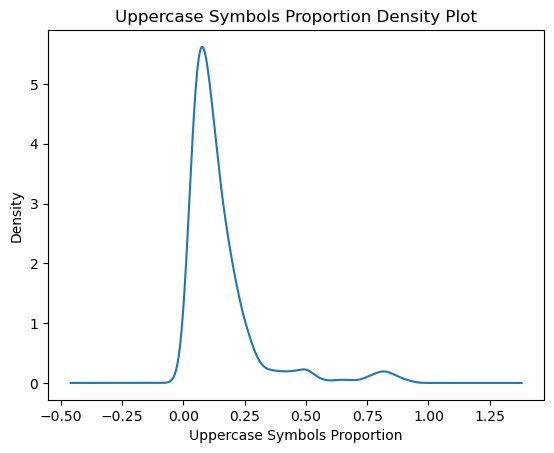

In [14]:
def uppercase_proportion(text):
    uppercase_count = sum(x.isupper() for x in text)
    total_chars = len(text)
    
    if total_chars == 0:
        return 0
    
    return uppercase_count / total_chars

data['uppercase_proportion'] = data['text'].apply(uppercase_proportion)

data['uppercase_proportion'].plot(kind='density')
plt.title('Uppercase Symbols Proportion Density Plot')
plt.xlabel('Uppercase Symbols Proportion')
plt.ylabel('Density')
plt.show()

Generating time-related variables

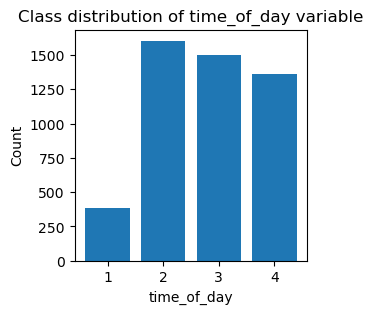

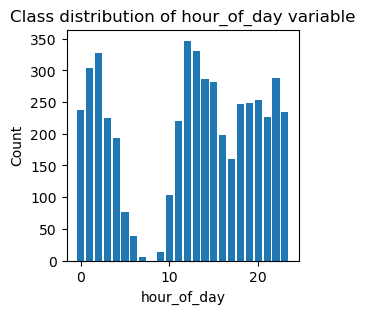

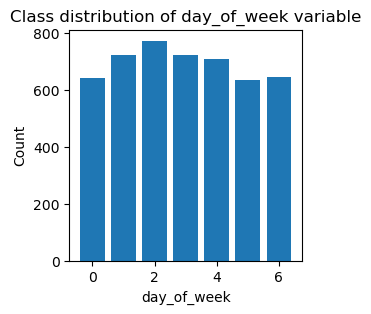

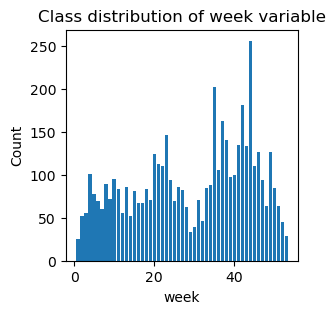

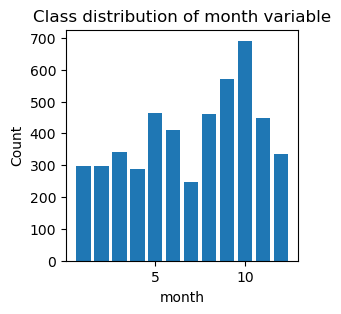

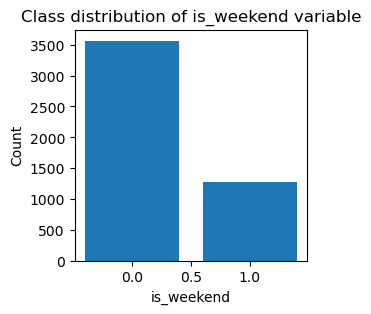

In [15]:
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 1  #morning
    elif 12 <= hour < 18:
        return 2  #midday
    elif 18 <= hour < 24:
        return 3  #evening
    else:
        return 4  #night
data['time_of_day'] = data['date'].dt.hour.apply(categorize_time_of_day)
plot_count_distribution(data, 'time_of_day')

data['hour_of_day'] = data['date'].dt.hour
plot_count_distribution(data, 'hour_of_day')

data['day_of_week'] = data['date'].dt.dayofweek
plot_count_distribution(data, 'day_of_week')

data['week'] = data['date'].dt.isocalendar().week
plot_count_distribution(data, 'week')

data['month'] = data['date'].dt.month
plot_count_distribution(data, 'month')

data['is_weekend'] = data['date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)
plot_count_distribution(data, 'is_weekend')

Convert isFlagged column to a binary variable

In [16]:
data['isFlagged'] = data['isFlagged'].map({'f': 0, 't': 1})

Creating a new column that will show the count of the number of user tags in the tweet

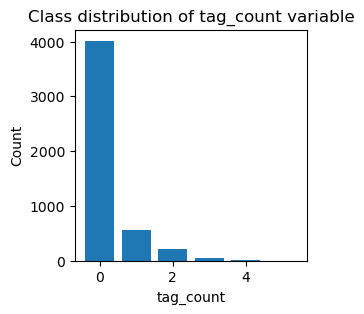

In [17]:
tag_pattern = r'@\w+'
data['tag_count'] = data['text'].apply(lambda x: len(re.findall(tag_pattern, x)))

#remove the user tags from the tweet
data['text'] = data['text'].str.replace(tag_pattern, '', flags=re.IGNORECASE)

plot_count_distribution(data, 'tag_count')

Creating a new column that will show the count of the number of hashtags in the tweet

In [18]:
hashtag_pattern = r'#\w+'
data['hashtag_count'] = data['text'].apply(lambda x: len(re.findall(hashtag_pattern, x)))

#remove the hash tags from the tweet
data['text'] = data['text'].str.replace(hashtag_pattern, '', flags=re.IGNORECASE)

Remove the occurrences of '&amp' from the tweet texts

In [19]:
data['text'] = data['text'].str.replace('&amp', '')

Clean the text and tokenize words

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ggnik\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ggnik\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [21]:
def clean_text(text):
    #remove symbols and keep only letters and spaces
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)

    #tokenize the text
    tokens = word_tokenize(cleaned_text)

    #convert tokens to lowercase
    tokens = [word.lower() for word in tokens]

    #remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    #join the tokens into a single string
    return ' '.join(filtered_tokens)

#apply the function
data['cleaned_text'] = data['text'].apply(clean_text)

Generate a word cloud from the cleaned text

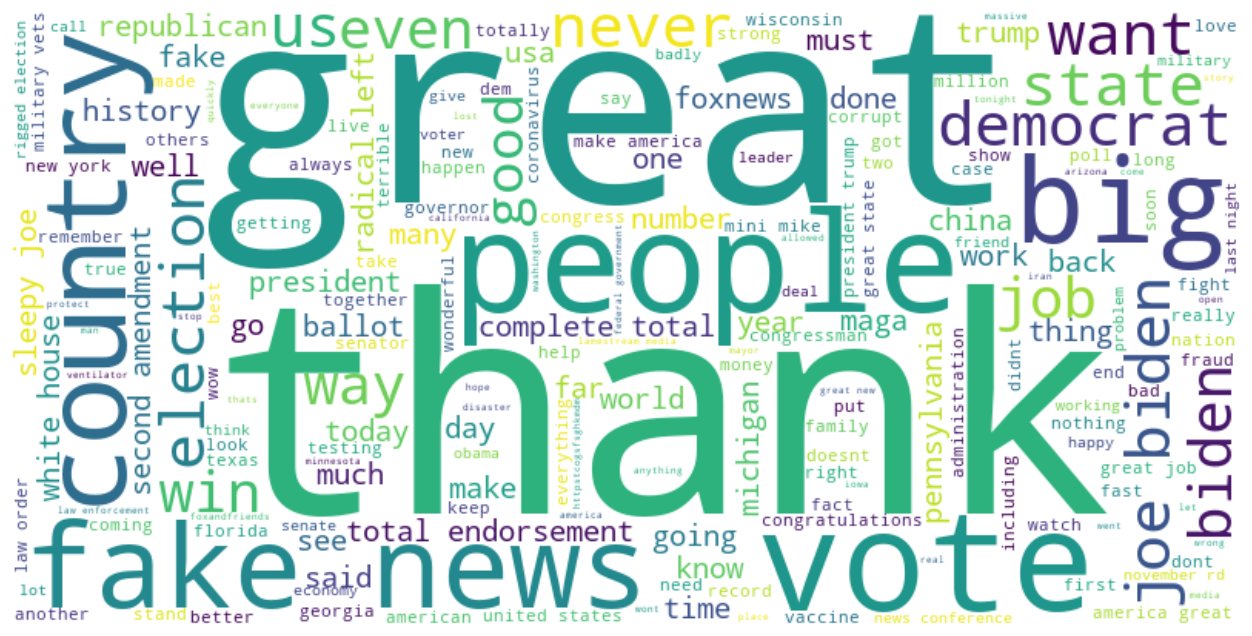

In [24]:
from wordcloud import WordCloud

#generate the word cloud
text = ' '.join(data['cleaned_text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Performing sentiment analysis on a cleaned text

In [27]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

#initialize the object
sia = SentimentIntensityAnalyzer()

#apply the sentiment analysis 
sentiments = []
for tweet in data['cleaned_text']:
    sentiment_score = sia.polarity_scores(tweet)
    sentiment = 0
    if sentiment_score['compound'] > 0.05:
        sentiment = 1
    elif sentiment_score['compound'] < -0.05:
        sentiment = -1
    sentiments.append(sentiment)
data['sentiment'] = sentiments

data.rename(columns={'likes': 'like_count'}, inplace=True)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ggnik\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Extract top 50 words that are most useful for predicting likes count and make the columns that indicate count of these words in a tweet

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor

In [32]:
def top_influential_words_rf(df, n):
    X, y = df['cleaned_text'], df['like_count']
    vectorizer = CountVectorizer()
    X_counts = vectorizer.fit_transform(X)
    
    # initialize and fit random forest model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_counts, y)
    
    # get feature names and their importances
    feature_names = vectorizer.get_feature_names_out()
    feature_importances = model.feature_importances_

    # get the index of top n influential words
    top_n_indices = np.argsort(-feature_importances)[:n]
    top_n_words = [feature_names[index] for index in top_n_indices]

    return top_n_words

top_50_words = top_influential_words_rf(data, n=50)

In [33]:
#generate tokens for these top 50 words
vectorizer = CountVectorizer(vocabulary=top_50_words)
X_top_50_counts = vectorizer.fit_transform(data['cleaned_text'])
tokenized_data = pd.DataFrame(X_top_50_counts.toarray(), columns=top_50_words)

#concatenate it to the original data
data.reset_index(drop=True, inplace=True)
tokenized_data.reset_index(drop=True, inplace=True)
data_with_tokens = pd.concat([data, tokenized_data], axis=1)

**Modelling** 

In [35]:
# import necessary libraries
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

Creating a dataframe for storing predictions and true response values

In [36]:
# creating a dataframe for storing predictions and true response values
prediction_results = pd.DataFrame(data.rename(columns={'like_count': 'response_true'})['response_true'])
# assign predictors and response columns to separate variables
X = data_with_tokens.select_dtypes(include=['float', 'int']).drop(['like_count', 'retweets'], axis=1)
y = data_with_tokens['like_count'].values
# scale the predictor variables
scaler = StandardScaler()
X = scaler.fit_transform(X)

1. Gradient Boosting Regressor model

In [37]:
#create the gradient boosting classifier object
gb_model = GradientBoostingRegressor()

#define the dictionary of hyperparameters for tuning
gb_param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4, 5],
    'max_features': ['sqrt', 'log2', None]
}

#create and fit an object for hyperparameter tuning
gb_grid_search = GridSearchCV(gb_model,
                              param_grid=gb_param_grid, 
                              cv=KFold(n_splits=10), 
                              scoring='r2',
                              n_jobs=-1).fit(X, y)

#print out the best set of parameters and the corresponding R2 score
print("Best parameters:", gb_grid_search.best_params_)
print("R2:", gb_grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
R2: 0.4734198245911919


In [38]:
#retrieve the best hyperparameters obtained from the grid search
gb_best_params = gb_grid_search.best_params_

#create a classifier passing the hyperparameters
gb_model = GradientBoostingRegressor(
    learning_rate=gb_best_params['learning_rate'],
    n_estimators=gb_best_params['n_estimators'],
    max_depth=gb_best_params['max_depth'],
    max_features=gb_best_params['max_features']
)

#create a CV object with 10 folds
cv = KFold(n_splits=10)

#create an empty array to store the predicted probabilities for each test sample
gb_preds = np.empty((y.shape[0]))

#loop over each fold of the data
for train_index, test_index in cv.split(X):
    #get the training and test data for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #fit the model
    gb_model.fit(X_train, y_train)

    #predict the probabilites and write them to an array
    gb_preds[test_index] = gb_model.predict(X_test)

#add the column with predicted probabilities to a data frame
prediction_results = pd.concat([
    prediction_results, 
    pd.DataFrame(gb_preds).iloc[:,0].rename('gradient_boosting')
], axis=1)

In [39]:
#fit the model
gb_model.fit(X, y)

#get the importance scores
importance_scores = gb_model.feature_importances_

#create a dictionary with column names and importance scores
feature_importance = dict(zip(data_with_tokens.select_dtypes(include=['float', 'int']).drop(['like_count', 'retweets'], axis=1).columns, 
                              importance_scores))

#sort the dictionary
sorted_feature_importance = {k: v for k, v in sorted(feature_importance.items(), 
                                                     key=lambda item: item[1], 
                                                     reverse=True)}

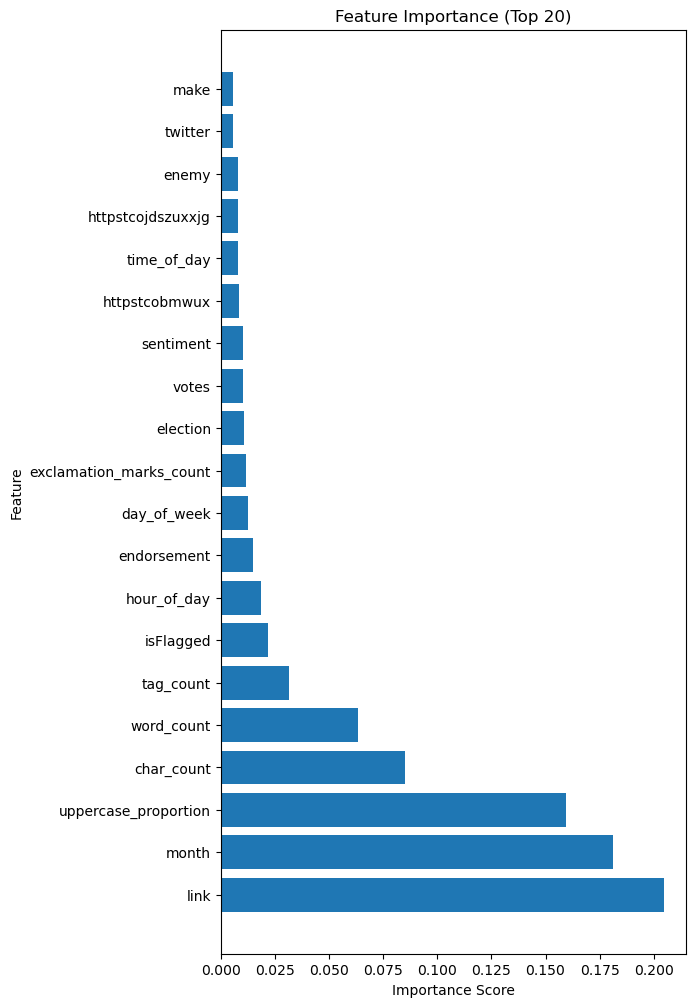

In [42]:
from itertools import islice

#get the top 20 most significant features
top_features = dict(islice(sorted_feature_importance.items(), 0, 20))

#plot a bar chart
fig, ax = plt.subplots(figsize=(6, 12), dpi=100)
ax.barh(range(len(top_features)), 
        list(top_features.values()), 
        align='center')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(list(top_features.keys()))
ax.set_xlabel('Importance Score')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance (Top 20)')
plt.show()

2. Ridge regularised regression model

In [43]:
ridge_model = Ridge()
ridge_param_grid = {
    'alpha':  np.arange(0.1, 10, 0.1).tolist()
}

ridge_grid_search = GridSearchCV(ridge_model,
                                 param_grid=ridge_param_grid,
                                 cv=KFold(n_splits=10),
                                 scoring='r2',
                                 n_jobs=-1).fit(X, y)

print("Best parameters:", ridge_grid_search.best_params_)
print("R2:", ridge_grid_search.best_score_)

Best parameters: {'alpha': 9.9}
R2: 0.3618455649769473


In [44]:
ridge_best_params = ridge_grid_search.best_params_

ridge_model = Ridge(alpha=ridge_best_params['alpha'])

cv = KFold(n_splits=20)

ridge_preds = np.empty((y.shape[0]))

#create an empty array to store the coefficients 
ridge_coefs = []

for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ridge_model.fit(X_train, y_train)
    
    #store the coefficients
    ridge_coefs.append(ridge_model.coef_)

    ridge_preds[test_index] = ridge_model.predict(X_test)

prediction_results = pd.concat([
    prediction_results, 
    pd.DataFrame(ridge_preds).iloc[:,0].rename('ridge_regression')
], axis=1)

In [46]:
#average the coefficients across folds
ridge_coefs = np.array(ridge_coefs)
ridge_coefs_avg = ridge_coefs.mean(axis=0)

#create the dataframe with column names for each predictor and display top 10 features
coef_df = pd.DataFrame({'Variable': list(data_with_tokens.select_dtypes(include=['float', 'int']).drop(['like_count', 'retweets'], axis=1).columns), 'Coefficient': ridge_coefs_avg})
coef_df['abs_coefficient'] = np.abs(coef_df['Coefficient'])
coef_df_sorted = coef_df.sort_values(by='abs_coefficient', ascending=False)
coef_df_sorted.head(10)

,Variable,Coefficient,abs_coefficient
2,link,-40100.568577,40100.568577
4,char_count,-28816.317705,28816.317705
3,word_count,21336.353031,21336.353031
12,month,17125.572725,17125.572725
8,uppercase_proportion,14994.304243,14994.304243
14,tag_count,-11332.656824,11332.656824
0,isFlagged,6133.722137,6133.722137
42,httpstcojdszuxxjg,5834.071966,5834.071966
36,enemy,5771.417816,5771.417816
38,httpstcobmwux,5651.135081,5651.135081


<Figure size 600x1800 with 0 Axes>

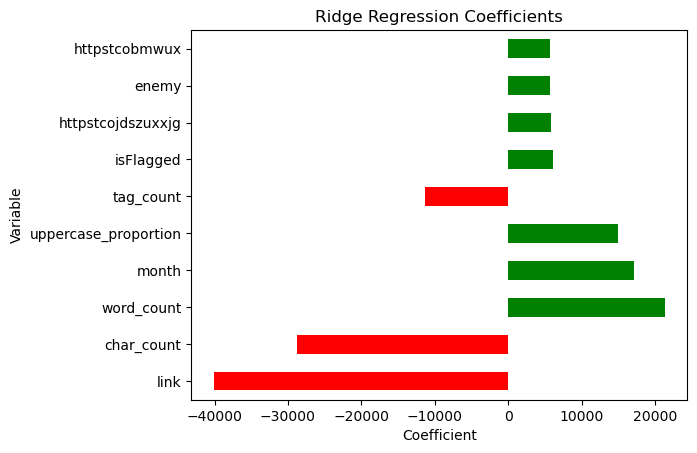

In [47]:
plt.figure(figsize=(6, 18))
#create a color list based on the sign
colors = ['green' if coef >= 0 else 'red' for coef in coef_df_sorted.head(10)['Coefficient']]
#plot the bar chart
coef_df_sorted.head(10).plot(kind='barh', x='Variable', y='Coefficient', legend=None, color=colors)
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.title('Ridge Regression Coefficients')
plt.show()

In [49]:
prediction_results

,response_true,gradient_boosting,ridge_regression
0,177470,128968.596233,144489.511430
1,187683,110744.411241,115996.690088
2,33992,65810.304233,51945.458707
3,91024,84549.846452,62719.105266
4,124902,76222.365511,40320.605885
...,...,...,...
4844,39586,43608.013759,28864.301153
4845,44575,57937.094269,39704.322797
4846,24138,25290.383027,25004.145122
4847,57264,65420.617816,56828.857548


Model performance evaluation

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#extract true values and predictions
y_true = prediction_results['response_true']
gb_preds = prediction_results['gradient_boosting']
rr_preds = prediction_results['ridge_regression']
ens_preds = prediction_results[['gradient_boosting', 'ridge_regression']].mean(axis=1)

#calculate MSE, MAE, and R2
def evaluate_model(y_true, preds):
    mse = mean_squared_error(y_true, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)
    return mse, rmse, mae, r2

gb_metrics = evaluate_model(y_true, gb_preds)
rr_metrics = evaluate_model(y_true, rr_preds)
ens_metrics = evaluate_model(y_true, ens_preds)

evaluate_model(y_true, prediction_results.iloc[:,1:4].mean(axis=1))

#print out the metrics
def print_metrics(model_name, metrics):
    print(f"{model_name}:")
    print(f"Mean Squared Error: {metrics[0]:.2f}")
    print(f"Root Mean Squared Error: {metrics[1]:.2f}")
    print(f"Mean Absolute Error: {metrics[2]:.2f}")
    print(f"R2 score: {metrics[3]:.4f}\n")

print_metrics("Gradient Boosting Model", gb_metrics)
print_metrics("Ridge Regression Model", rr_metrics)
print_metrics("Ensemble model", ens_metrics)

Gradient Boosting Model:
Mean Squared Error: 3927457090.13
Root Mean Squared Error: 62669.43
Mean Absolute Error: 42360.79
R2 score: 0.4706

Ridge Regression Model:
Mean Squared Error: 4730545866.13
Root Mean Squared Error: 68778.96
Mean Absolute Error: 48785.35
R2 score: 0.3623

Ensemble model:
Mean Squared Error: 4123759001.84
Root Mean Squared Error: 64216.50
Mean Absolute Error: 44373.77
R2 score: 0.4441

